In [1]:
import os
import pydiffvg
from PIL import Image
import matplotlib.pyplot as plt
import torch
import numpy as np
from scipy.ndimage import gaussian_filter
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from skimage.transform import warp
from skimage import transform as tf
import imageio 
import matplotlib.font_manager as font_manager
import sys 
import torch
import torch.nn as nn
from torchvision import models, transforms
import PIL
from skimage.transform import resize
import torch.nn.functional as F

p = os.path.abspath('..')
sys.path.insert(1, p)
import sketch_utils as utils
from U2Net_.model import U2NET
from scipy import ndimage
from torchvision.utils import make_grid

device = torch.device("cuda:0" if (
            torch.cuda.is_available() and torch.cuda.device_count() > 0) else "cpu")

In [2]:
def get_clip_loss(path, layer):
    path_config = f"{path}/config.npy"
    config = np.load(path_config, allow_pickle=True)[()]
    loss_clip = np.array(config[f"loss_eval"])
    best_iter = np.argsort(loss_clip)[0]
    return loss_clip, best_iter

def get_ratios_dict(path_to_initial_sketches, rel_layer, layers, ratios_rel, images):
    final_w_iter = {}
    ratios_dict_per_layer_per_im = {}
    
    for l in layers:
        final_w_iter[l] = {}
        ratios_dict_per_layer_per_im[l] = {}
        
    for layer in layers:
        divs2 = []
        for im_name in images:
            path_l_rel = f"{path_to_initial_sketches}/ViT_l{rel_layer}_64s_{im_name}_mask/ViT_l{rel_layer}_64s_{im_name}_mask_seed0"
            loss_clip_l_rel, best_iter_rel = get_clip_loss(path_l_rel, rel_layer)
            best_lclip_rel = loss_clip_l_rel[best_iter_rel]

            path_li = f"{path_to_initial_sketches}/ViT_l{layer}_64s_{im_name}_mask/ViT_l{layer}_64s_{im_name}_mask_seed0"
            loss_clip_li, best_iter = get_clip_loss(path_li, layer)
            best_lclip_i = loss_clip_li[best_iter]

            div2 = best_lclip_i / best_lclip_rel
            divs2.append(div2)
            final_w_iter[layer][im_name] = div2
    
    a = ratios_rel
    b = range(len(a))
    points = np.array([(b_, a_) for (b_, a_) in zip(b, a)])
    
    for layer in final_w_iter.keys():
        for i, im_name in enumerate(final_w_iter[layer].keys()):
            # get x and y vectors
            x = points[:,0]
            y = points[:,1] / final_w_iter[layer][im_name]
            ratios_dict_per_layer_per_im[layer][im_name] = y
            
    return ratios_dict_per_layer_per_im

def get_svg_path(path):
    files = os.listdir(f"{path}")
    path_svg_ = [f for f in files if "svg" in f][0]
    path_svg = f"{path}/{path_svg_}"
    return path_svg

def read_svg(path_svg, multiply=False):
    device = torch.device("cuda" if (
        torch.cuda.is_available() and torch.cuda.device_count() > 0) else "cpu")
    canvas_width, canvas_height, shapes, shape_groups = pydiffvg.svg_to_scene(
        path_svg)
    if multiply:
        canvas_width *= 2
        canvas_height *= 2
        for path in shapes:
            path.points *= 2
            path.stroke_width *= 2
    _render = pydiffvg.RenderFunction.apply
    scene_args = pydiffvg.RenderFunction.serialize_scene(
        canvas_width, canvas_height, shapes, shape_groups)
    img = _render(canvas_width,  # width
                  canvas_height,  # height
                  2,   # num_samples_x
                  2,   # num_samples_y
                  0,   # seed
                  None,
                  *scene_args)
    img = img[:, :, 3:4] * img[:, :, :3] + \
        torch.ones(img.shape[0], img.shape[1], 3,
                   device=device) * (1 - img[:, :, 3:4])
    img = img[:, :, :3].cpu().numpy()
    return img

In [3]:
path_to_initial_sketches = "/home/vinker/dev/background_project/experiements/big_test_07_27/"
rel_layer = 8
layers = [4, 5, 7, 8, 11]
ratios_rel = [16,11.95,10.03,6.44,3.567,2.518,1.721,1.02]
images = ["woman_city", "semi-complex", "man_flowers"]
images = ["man_flowers"]


ratios_dict_per_layer_per_im = get_ratios_dict(path_to_initial_sketches, rel_layer, layers, ratios_rel, images)
for l in ratios_dict_per_layer_per_im.keys():
    print(f"\n===== layer {l} ====")
    for n in ratios_dict_per_layer_per_im[l]:
        weights_str = ""
        for r_ in ratios_dict_per_layer_per_im[l][n]:
            r_str = f"{r_:.3f}"
            weights_str += f"{float(r_str)},"
        weights_str = weights_str[:-1]
        print(n, weights_str)
        # print(n, [float(f"{r_:.3f}") for r_ in ratios_dict_per_layer_per_im[l][n]])


path_to_res = "/home/vinker/dev/background_project/experiements/ratio_loss_objects_09_04/"




===== layer 4 ====
man_flowers 47.774,35.681,29.948,19.229,10.651,7.518,5.139,3.046

===== layer 5 ====
man_flowers 45.042,33.641,28.236,18.13,10.042,7.089,4.845,2.871

===== layer 7 ====
man_flowers 29.295,21.879,18.364,11.791,6.531,4.61,3.151,1.868

===== layer 8 ====
man_flowers 16.0,11.95,10.03,6.44,3.567,2.518,1.721,1.02

===== layer 11 ====
man_flowers 5.119,3.823,3.209,2.06,1.141,0.806,0.551,0.326


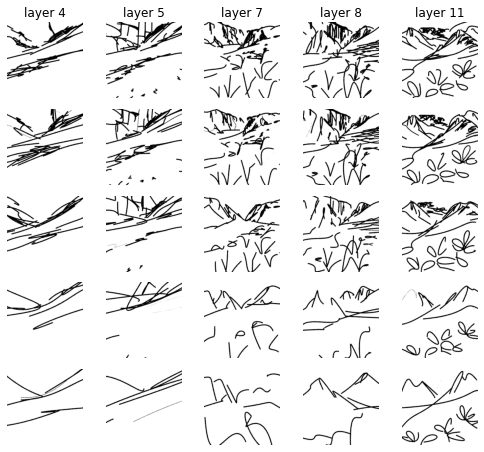

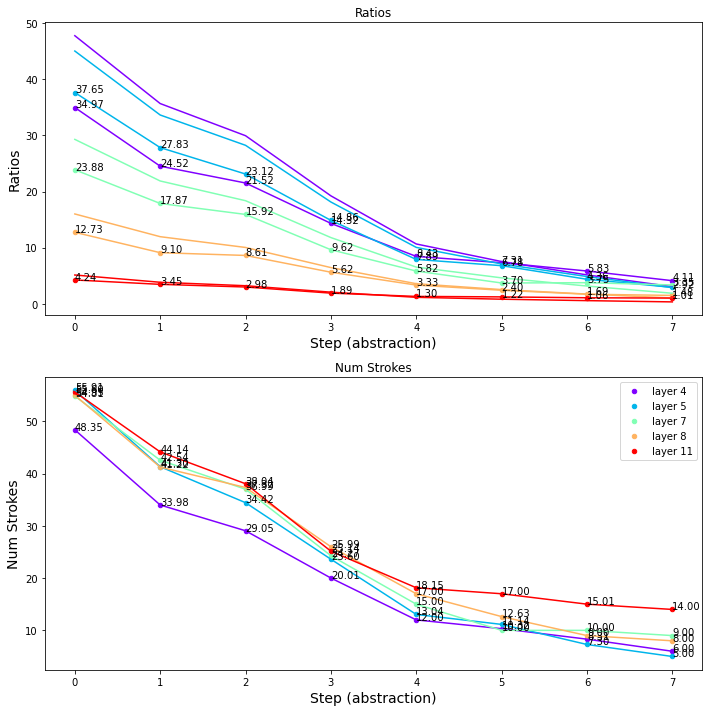

In [4]:
import matplotlib.cm as cm


def fix_r(r):
    r__ = r
    if r__ == 1.076:
        r__ = "1.075"
    if r__ == 0.626:
        r__ = "0.625"
    if r__ == 0.551:
        r__ = "0.55"
    if r__ == 3.605:
        r__ = "3.604"
    if r__ == 1.943:
        r__ = "1.942"
    if r__ == 0.76:
        r__ = "0.759"
    if r__ == 0.308:
        r__ = "0.307"
    if r__ == 4.346:
        r__ = "4.345"
    if r__ == 2.342:
        r__ = "2.341"
    if r__ == 0.916:
        r__ = "0.915"
    if r__ == 0.371:
        r__ = "0.37"
    if r__ == 0.806:
        r__ = "0.805"
    return r__

def get_seed(filename):
    filename = filename[:-9]
    keyword = 'seed'
    before_keyword, keyword, after_keyword = filename.partition(keyword)
    return after_keyword

final_ratio_per_l_per_im = {}
final_num_s_per_l_per_im = {}
for l in layers:
    final_ratio_per_l_per_im[l] = {}
    final_num_s_per_l_per_im[l] = {}

for im_name in images:
    figa = plt.figure(figsize=(7,10))
    for i, layer in enumerate(layers):
        path_best_im = get_svg_path(f"{path_to_initial_sketches}/ViT_l{layer}_64s_{im_name}_mask")
        im = read_svg(path_best_im)
        plt.subplot(len(ratios_rel), len(layers), i + 1)
        plt.imshow(im)
        plt.title(f"layer {layer}")  
        plt.axis("off")
        
        ratios = ratios_dict_per_layer_per_im[layer][im_name]
        ratios_res = []
        num_strokes_res = []
        k = 0
        for j, r in enumerate(ratios):
        # for j, r in enumerate(ratios[0:len(ratios) + 1:2]):
            r_ = float(f"{r:.3f}")
            r__ = fix_r(r_)
            res_filename = f"ratio{r__}_points-mlp1_opt1_gradnorm_clip_l{layer}L2__64s_{im_name}_mask"
            path_best_im = get_svg_path(f"{path_to_res}/{res_filename}")
            im = read_svg(path_best_im)
            if j % 2 == 0:
                plt.subplot(len(ratios_rel), len(layers), (k + 1) * len(layers) + i + 1)
                plt.imshow(im)
                plt.axis("off")
                k += 1
        
            seed = get_seed(os.path.split(path_best_im)[-1])
            path_conf = f"{path_to_res}/{res_filename}/{res_filename}_seed{seed}/config.npy"
            config = np.load(path_conf, allow_pickle=True)[()]
            
            loss_clip = np.array(config[f"clip_vit_l{layer}_original_eval"])
            loss_width = np.array(config["width_loss_original_eval"])
            best_iter = int(config["best_normalised_iter"] / config["eval_interval"])
            
            width_loss_ = loss_width[best_iter]
            clip_loss_ = loss_clip[best_iter]
            ratio = width_loss_ / clip_loss_
            ratios_res.append(ratio)
            
            num_strokes = np.array(config["num_strokes"])[best_iter].cpu()
            num_strokes_res.append(num_strokes)
            
        final_ratio_per_l_per_im[layer][im_name] = ratios_res
        final_num_s_per_l_per_im[layer][im_name] = num_strokes_res
        
    plt.tight_layout()
    plt.savefig(f"matrix_07_09/{im_name}.png")
    plt.show()
    plt.close()
    
    
# plot graphs
for im_name in images:
    figa = plt.figure(figsize=(10,10))
    colors = cm.rainbow(np.linspace(0, 1, len(layers)))
    
    for i, layer in enumerate(layers):        
        ratios = ratios_dict_per_layer_per_im[layer][im_name]
        ratios_res = final_ratio_per_l_per_im[layer][im_name]
        num_strokes_res = final_num_s_per_l_per_im[layer][im_name] 
    
    
        plt.subplot(2,1,1)
        plt.plot(range(len(ratios)), ratios, c=np.array([colors[i]]))
        plt.plot(range(len(ratios_res)), ratios_res, c=np.array([colors[i]]))
        plt.scatter(range(len(ratios_res)), ratios_res, label=f"layer {layer}", s=20, c=np.array([colors[i]]))
        for k in range(len(ratios_res)):
            plt.annotate("{:.2f}".format(ratios_res[k]), (range(len(ratios_res))[k], ratios_res[k]), fontsize=10)
        plt.ylabel("Ratios", fontsize=14)
        plt.xlabel("Step (abstraction)", fontsize=14)
        plt.title("Ratios")
        
        plt.subplot(2,1,2)
        plt.plot(range(len(num_strokes_res)), num_strokes_res, c=np.array([colors[i]]))
        plt.scatter(range(len(num_strokes_res)), num_strokes_res, label=f"layer {layer}", s=20, c=np.array([colors[i]]))
        for k in range(len(num_strokes_res)):
            plt.annotate("{:.2f}".format(num_strokes_res[k]), (range(len(num_strokes_res))[k], num_strokes_res[k]), fontsize=10)
        plt.ylabel("Num Strokes", fontsize=14)
        plt.xlabel("Step (abstraction)", fontsize=14)
        plt.title("Num Strokes")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"matrix_07_09/{im_name}_graph.png")
    plt.show()
    plt.close()
            